<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.5.3.1-LSTMB16-GloVe_with_stop-1m-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained embedding using LSTM with 1 million samples without removing stop words

For this notebook, we will run our 16 unit LSTM using GloVe embedding with 1 million examples to see how to model does.

We are going to feed in text where we have not removed stop words using NLTK to see how our model performs

Notebook where we ran the same model but on a corpus with stopwords removed: [6.5.3-LSTMB16-GloVe-1m-prototype.ipynb](6.5.3-LSTMB16-GloVe-1m-prototype.ipynb)

Score for our model for that run: 0.2959231917086992


# Result

Our score: 0.33342223919687963

Looks like there is a ~0.04 improvment in the model score if we do not remove stop words from the corpus, but this is still much lower than Logistic Regression which gave us a score of around 0.49


In [5]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, No Dropout, GloVe Embedding (with stop words), Balanced Weights"
FEATURE_SET_NAME = "glove_with_stop"
PATIENCE = 4

SAMPLES = "1m"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename('glove_embedding_with_stop-dl_prototype-report.csv')


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'

# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100




In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [8]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=110014
Number of Documents=748261
Train review vectors shape: (748261, 100)  Test review vectors shape: (249421, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [9]:
print('Indexing word vectors.')

embeddings_index = {}
with open(EMBEDDING_FILE) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [10]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 110015
embedding_matrix shape: (110016, 300)
Number of missing words from our vocabulary: 47523


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_index)+1

# building our network
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
model.add(Embedding(input_dim=vocab_size,
                            output_dim=EMBED_SIZE,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
# model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          33004800  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 33,025,173
Trainable params: 20,373
Non-trainable params: 33,004,800
_________________________________________________________________
None


In [14]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                            #   factor=0.4,
                            #   patience=PATIENCE, 
                            #   min_lr=0.00001,
                            #  mode='auto',
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42416136 3.02566264 2.20479774 1.20121605 0.37295617]
Number of training examples: 748261
Train on 598608 samples, validate on 149653 samples
Epoch 1/50
598608/598608 [==============================] - 65s 108us/sample - loss: 0.8650 - categorical_accuracy: 0.6629 - val_loss: 0.7990 - val_categorical_accuracy: 0.6869
Epoch 2/50
598608/598608 [==============================] - 55s 92us/sample - loss: 0.7812 - categorical_accuracy: 0.6926 - val_loss: 0.7734 - val_categorical_accuracy: 0.6968
Epoch 3/50
598608/598608 [==============================] - 56s 94us/sample - loss: 0.7602 - categorical_accuracy: 0.7003 - val_loss: 0.7619 - val_categorical_accuracy: 0.7002
Epoch 4/50
598608/598608 [==============================] - 58s 97us/sample - loss: 0.7485 - categorical_accuracy: 0.7050 - val_loss: 0.7522 - val_categorical_accuracy: 0.7031
Epoch 5/50
598608/598608 [==============================] - 58s 96us/sample - loss: 0.7406 - categorical_accuracy: 0.7080 - val_loss: 0

Number of test: 249421
Running model.evaluate...
249421/249421 [==============================] - 39s 154us/sample - loss: 0.7288 - categorical_accuracy: 0.7136
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(249421, 5)
Getting classification report...
Accuracy: 71.36%


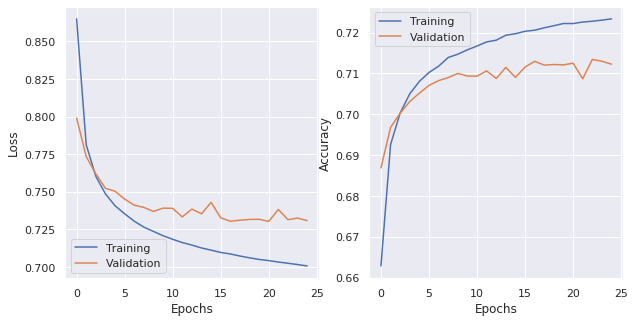


Confusion Matrix
[[ 28724   1969   2486    249   1591]
 [  7608   2420   4668    668   1236]
 [  3319   1542   9435   3982   3993]
 [   936    305   4613  12555  23226]
 [  1248    144   1726   5933 124845]]

Classification Report
              precision    recall  f1-score   support

           1       0.69      0.82      0.75     35019
           2       0.38      0.15      0.21     16600
           3       0.41      0.42      0.42     22271
           4       0.54      0.30      0.39     41635
           5       0.81      0.93      0.86    133896

    accuracy                           0.71    249421
   macro avg       0.56      0.52      0.53    249421
weighted avg       0.68      0.71      0.68    249421



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

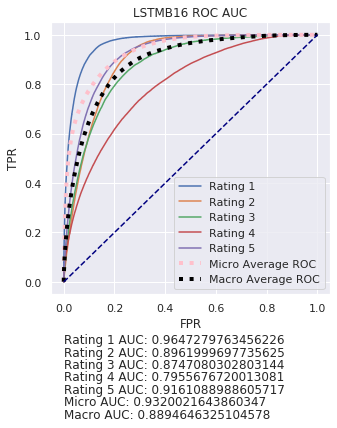

In [17]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [18]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.33342223919687963


**Save off various files**

In [19]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16-1x16-glove_with_stop-sampling_none-997682-100-star_rating
Saving to report file: drive/My Drive/Springboard/capstone/reports/glove_embedding_with_stop-dl_prototype-report.csv
{'model_name': 'LSTMB16', 'architecture': '1x16', 'description': '1 Layer 16 LSTM Units, No Dropout, GloVe Embedding (with stop words), Balanced Weights', 'classification_report': '{"1": {"precision": 0.6866021274052827, "recall": 0.8202404409035096, "f1-score": 0.7474952507351602, "support": 35019}, "2": {"precision": 0.3793103448275862, "recall": 0.14578313253012049, "f1-score": 0.2106179286335944, "support": 16600}, "3": {"precision": 0.4115055826936497, "recall": 0.42364509900767816, "f1-score": 0.41748711254673776, "support": 22271}, "4": {"precision": 0.5368367041518792, "recall": 0.30154917737480486, "f1-score": 0.38617698625080743, "support": 41635}, "5": {"precision": 0.8060184258607666, "recall": 0.9324027603513174, "f1-score": 0.8646164820438592, "support": 133896}, "accuracy": 0.71

# Test That Our Models Saved Correctly

In [20]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


249421/249421 [==============================] - 124s 497us/sample - loss: 0.7288 - categorical_accuracy: 0.7136
Accuracy: 71.36%


In [21]:
print(datetime.now())

2020-02-15 03:09:39.320844
